# Uche Okoro
## MET CS 767 O2 Fall 2020
## BRECAD (Breast Cancer Detection)

In [1]:
# importing packages and modules
import time
start_time = time.time()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore') 

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Recall
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [3]:
# set appropriate style for all plots
sns.set(style='whitegrid')

In [4]:
# read the dataset from a csv file into a pandas dataframe
breast_cancer = pd.read_csv('wbcd.csv')

In [5]:
# look at the first 5 rows
breast_cancer.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [6]:
cols = breast_cancer.columns

In [7]:
# drop the id column as it serves no purposes with respect to classification
breast_cancer.drop([cols[-1], cols[0]], inplace=True, axis=1)

In [8]:
# collect all the feature names in cols
cols = cols[1:-1]

In [9]:
# look at the first 5 rows again
breast_cancer.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


According to the aggregate below, there are 357 benign records and 212 malignant records.

In [10]:
# obtain a count of the unique values in the target variable
target_values = list(breast_cancer['diagnosis'].value_counts().keys())
breast_cancer['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [11]:
# Target variable must be categorical with only 2 possible values: 'M' and 'B'
if (len(target_values)==2 and ('B' in target_values) and ('M' in target_values)):
    print('Target Variable is in the Correct Format.')
else:
    print('Error! Please Verify The Dataset.')

Target Variable is in the Correct Format.


In [12]:
data = pd.DataFrame(breast_cancer['diagnosis'].value_counts())

In [13]:
# obtain the shape of the data
breast_cancer.shape

(569, 31)

In [14]:
# obtain a summary of the data
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [15]:
for i in cols[1:]:
    # scan through all the features and check the datatype
    if breast_cancer[i].dtype != np.float64:
        print('Error! Please Verify The Dataset.')
else:
    print('All Features are in the Correct Format')

All Features are in the Correct Format


In [16]:
for k in cols[1:]:
    # scan through all the features and make sure no values are negative i.e -99
    if breast_cancer[k].min() < 0:
        print('Error! Please Verify The Dataset.')
else:
    print('All Features are in the Correct Format')

All Features are in the Correct Format


In [17]:
# isolate the features into
features = breast_cancer[cols[1:]]
features.head(2)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [18]:
# isolate the target variable
target = breast_cancer['diagnosis']
target[:5]

0    M
1    M
2    M
3    M
4    M
Name: diagnosis, dtype: object

In [19]:
# obtain a statistical summary of the data
breast_cancer.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


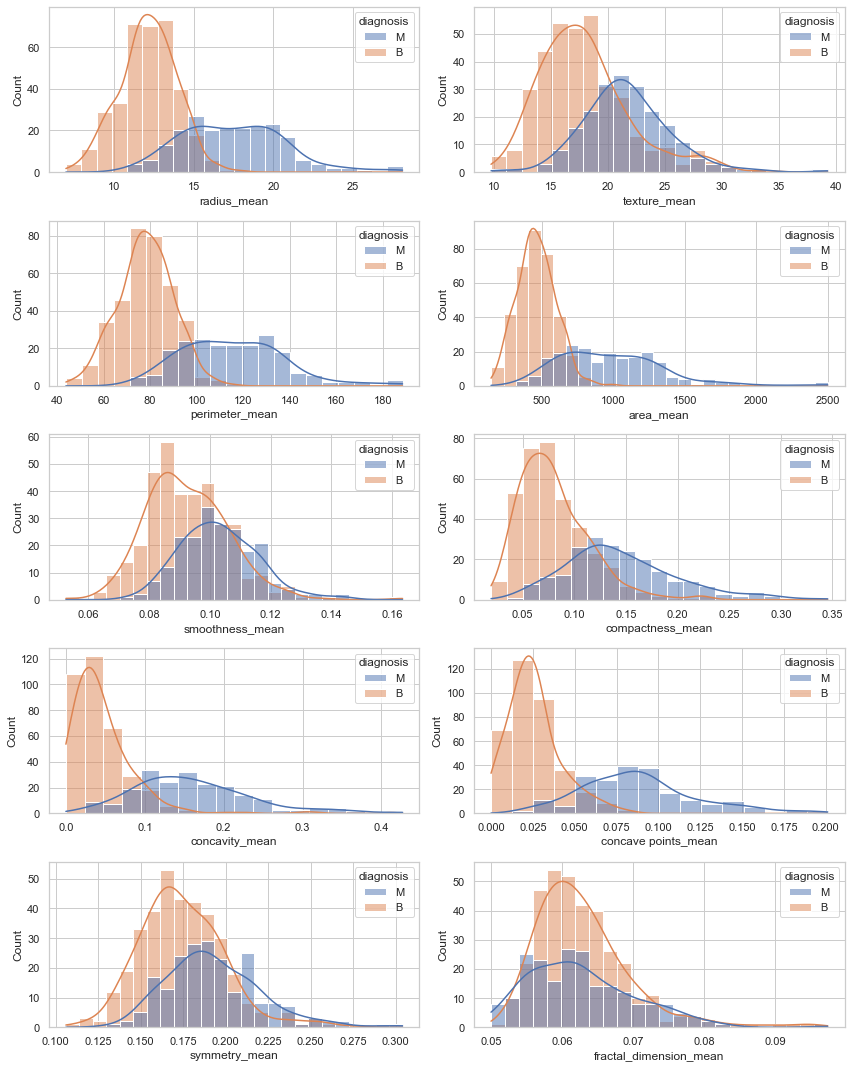

In [20]:
fig = plt.figure(figsize=(12,15))

for i,j in enumerate(breast_cancer.columns[1:11], start=1):
    ax = fig.add_subplot(5,2,i)
    # plot histograms of all the features in the dataset
    sns.histplot(x=j, data=breast_cancer, hue='diagnosis', kde=True, ax=ax)

plt.tight_layout()
plt.show()  

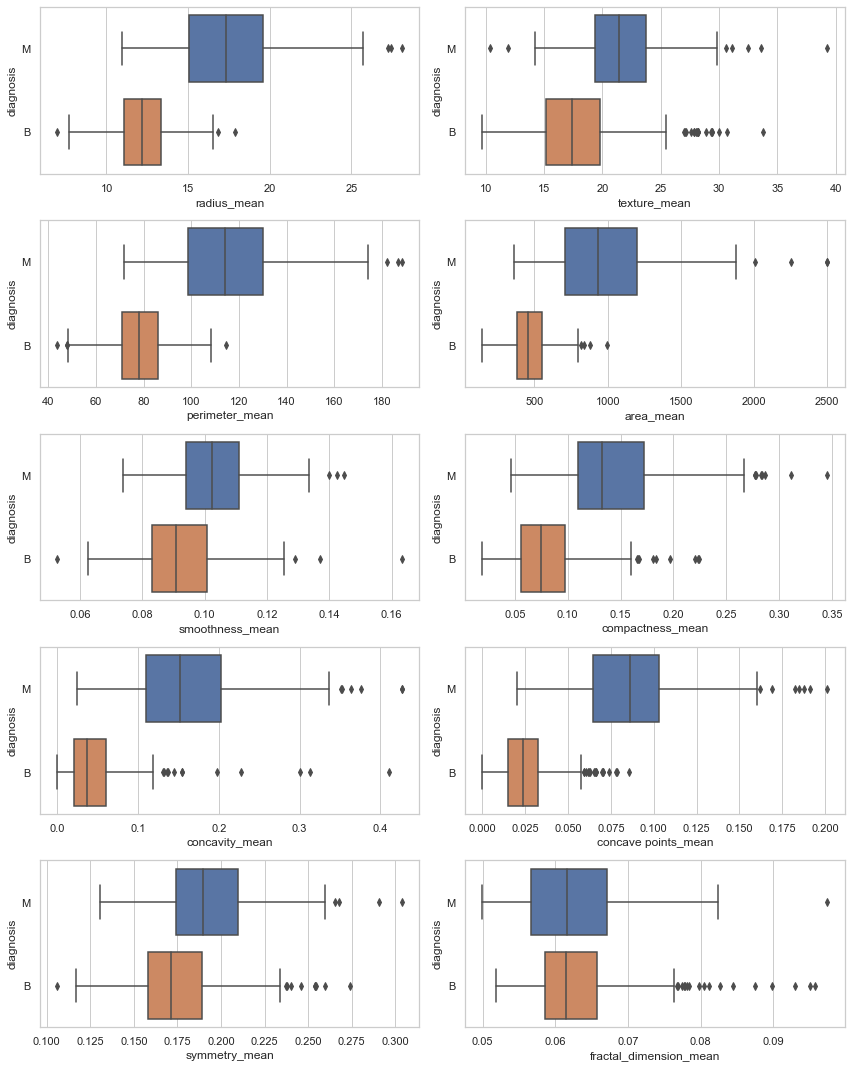

In [21]:
fig = plt.figure(figsize=(12,15))
benign = breast_cancer[target==0]
malignant = breast_cancer[target==1]

for i,j in enumerate(breast_cancer.columns[1:11], start=1):
    ax = fig.add_subplot(5,2,i)
    # plot boxplots of all the features in the dataset
    sns.boxplot(x=j, y='diagnosis', data=breast_cancer, ax=ax)

plt.tight_layout()
plt.show()  

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

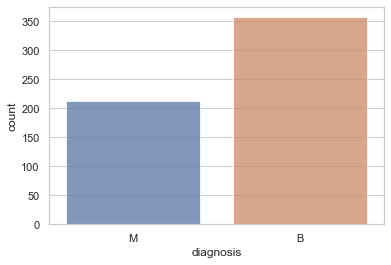

In [22]:
# plot bars of the unique values in the target variable
sns.countplot(x='diagnosis', data=breast_cancer, alpha=0.75)

In [23]:
# encode the target variable to 0's for benign and 1's for malignant
le = LabelEncoder()
breast_cancer['diagnosis'] = le.fit_transform(breast_cancer['diagnosis'])
target = le.fit_transform(target)
target[:5]

array([1, 1, 1, 1, 1])

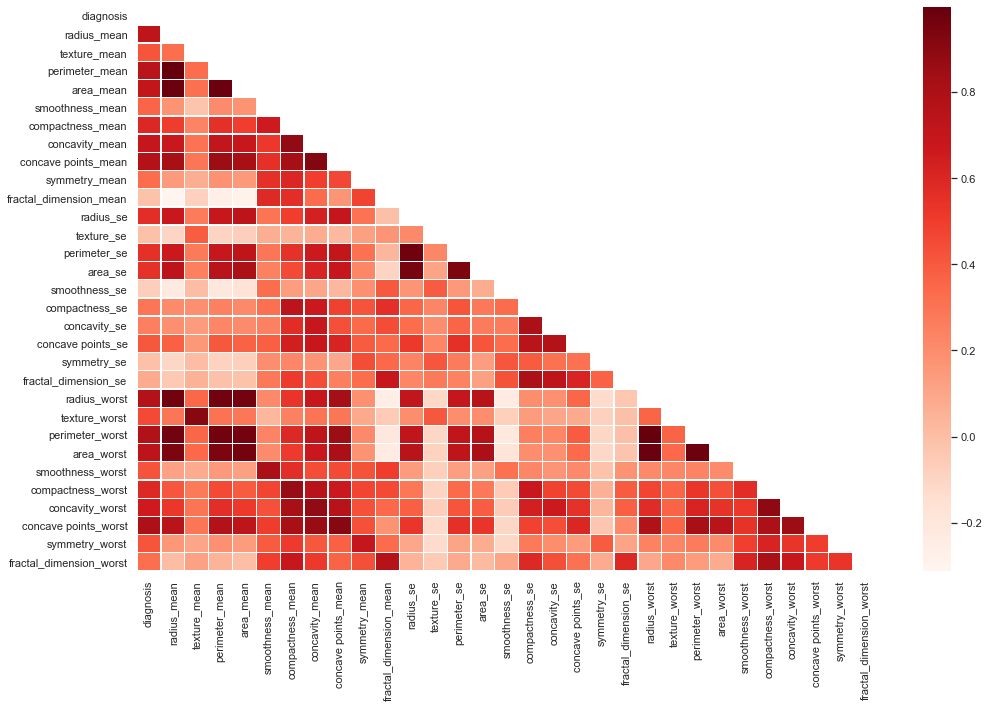

In [24]:
# create a correlation matrix of all the features and target variable to measure collinearity.
breast_corr = breast_cancer.corr()
mask = np.zeros_like(breast_corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15, 10))
sns.heatmap(breast_corr, mask=mask, cmap="Reds", linewidths=0.25)
plt.tight_layout()

In [25]:
# z-score normalization of the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [26]:
breast_cancer.isnull().sum() # checking for missing values/null cells

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

### Initial Data Splitting (80% Train and 20% Test)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.20, random_state=23)

### Secondary Data Splitting for Validation Set in NN (60% Train and 20% Validation)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=23)

### Dummy Classifier Classification Code

In [29]:
from sklearn.dummy import DummyClassifier
# Create A Baseline using a simple rule- 
# Predict values based on distribution of training set.
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)
y_pred_dc = dummy.predict(y_test)

In [30]:
def perf_scores(y_true, y_hat):
    c_m = confusion_matrix(y_true, y_hat) # confusion matrix
    acc_score = accuracy_score(y_true, y_hat) # accuracy score
    roc_score = roc_auc_score(y_true, y_hat) # auc score
    tn = c_m[0,0] # true negatives
    fn = c_m[1,0] # false negatives
    tp = c_m[1,1] # true positives
    fp = c_m[0,1] # false positives
    tpr = c_m[1,1]*100/np.sum(c_m[1,:]) # true positive rate
    tnr = c_m[0,0]*100/np.sum(c_m[0,:]) # true negative rate
    ppv = c_m[1,1]*100/np.sum(c_m[:,1]) # (precision) positive predictive value
    return (acc_score, roc_score, tpr, tnr, ppv)

In [31]:
def conf_mat(y_true, y_hat, model):
    c_m = confusion_matrix(y_true, y_hat)
    print("Performance Metrics for: {:s}".format(model))
    print("Accuracy Score: {:.3f}".format(accuracy_score(y_true, y_hat)))
    print("Receiving Operating Characteristics Score: {:.3f}".format(roc_auc_score(y_true, y_hat)))
    print("True Negatives: {}".format(c_m[0,0]))
    print("False Negatives: {}".format(c_m[1,0]))
    print("True Positives: {}".format(c_m[1,1]))
    print("False Positives: {}".format(c_m[0,1]))
    print("TPR: {:.3f}".format(c_m[1,1]*100/np.sum(c_m[1,:])))
    print("TNR: {:.3f}".format(c_m[0,0]*100/np.sum(c_m[0,:])))
    print("PPV (Precision): {:.3f}".format(c_m[1,1]*100/np.sum(c_m[:,1])))

In [32]:
print('Confusion Matrix for Dummy Classifier:\n')
print(confusion_matrix(y_test, y_pred_dc))

Confusion Matrix for Dummy Classifier:

[[44 31]
 [27 12]]


In [33]:
conf_mat(y_test, y_pred_dc, 'Dummy Classifier')

Performance Metrics for: Dummy Classifier
Accuracy Score: 0.491
Receiving Operating Characteristics Score: 0.447
True Negatives: 44
False Negatives: 27
True Positives: 12
False Positives: 31
TPR: 30.769
TNR: 58.667
PPV (Precision): 27.907


In [34]:
print('Classification Report for Dummy Classifier:\n')
print(classification_report(y_test, y_pred_dc))

Classification Report for Dummy Classifier:

              precision    recall  f1-score   support

           0       0.62      0.59      0.60        75
           1       0.28      0.31      0.29        39

    accuracy                           0.49       114
   macro avg       0.45      0.45      0.45       114
weighted avg       0.50      0.49      0.50       114



### Neural Network Classification Code with TF and Keras

#### First a quick understanding of the TF library

In [35]:
epochs = 25
batch_size = 20
# convert X_test to tensor to pass through model (train data will be converted to
# tensors directly)
X_train_tf = X_train.copy()
X_test_tf = tf.Variable(X_test)

In [36]:
def get_batch(x_data, y_data, batch_size):
    # write function to get the data in batches using a preset batch size
    idxs = np.random.randint(0, len(y_data), batch_size)
    return x_data[idxs,:], y_data[idxs]

In [37]:
# now declare the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random.normal([30, 15], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([15]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random.normal([15, 2], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([2]), name='b2')

In [38]:
def nn_model(x_input, W1, b1, W2, b2):
    # compile the neural network model
    x_input = tf.reshape(x_input, (x_input.shape[0], -1))
    x = tf.add(tf.matmul(tf.cast(x_input, tf.float32), W1), b1) 
    x = tf.nn.relu(x) # converting values using activation function
    logits = tf.add(tf.matmul(x, W2), b2) # tensor multiplication Wx + b for predictive values
    return logits # return set of logits corresponding to predictions

In [39]:
def loss_fn(logits, labels):
    # obtain loss from training the model
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    return cross_entropy

In [40]:
# setup the optimizer using Keras (the only help from Keras)
optimizer = tf.keras.optimizers.Adam()

In [41]:
total_batch = int(len(y_train)/batch_size)
for epoch in range(epochs):
    avg_loss = 0
    for i in range(total_batch):
        batch_x, batch_y = get_batch(X_train, y_train, batch_size=batch_size)
        # create tensors from features and target
        batch_x = tf.Variable(batch_x)
        batch_y = tf.Variable(batch_y)
        # create a one hot vector
        batch_y = tf.one_hot(batch_y, 2)
        with tf.GradientTape() as tape:
            logits = nn_model(batch_x, W1, b1, W2, b2)
            loss = loss_fn(logits, batch_y)
        gradients = tape.gradient(loss, [W1, b1, W2, b2])
        optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2]))
        avg_loss += loss/total_batch
    test_logits = nn_model(X_test, W1, b1, W2, b2)
    max_idxs = tf.argmax(test_logits, axis=1)
    # calculate test accuracies on the trained model
    test_acc = np.sum(max_idxs.numpy() == y_test)/len(y_test)
    print('Epoch: {:d}, loss= {:.3f}, test set accuracy= {:.3f}'.format((epoch+1), (avg_loss), (test_acc*100)))
print("\nTraining complete!")

Epoch: 1, loss= 1.129, test set accuracy= 65.789
Epoch: 2, loss= 1.037, test set accuracy= 65.789
Epoch: 3, loss= 0.896, test set accuracy= 67.544
Epoch: 4, loss= 0.549, test set accuracy= 78.070
Epoch: 5, loss= 0.364, test set accuracy= 85.088
Epoch: 6, loss= 0.352, test set accuracy= 90.351
Epoch: 7, loss= 0.265, test set accuracy= 92.105
Epoch: 8, loss= 0.163, test set accuracy= 92.982
Epoch: 9, loss= 0.179, test set accuracy= 94.737
Epoch: 10, loss= 0.180, test set accuracy= 94.737
Epoch: 11, loss= 0.148, test set accuracy= 93.860
Epoch: 12, loss= 0.113, test set accuracy= 94.737
Epoch: 13, loss= 0.135, test set accuracy= 95.614
Epoch: 14, loss= 0.112, test set accuracy= 95.614
Epoch: 15, loss= 0.110, test set accuracy= 97.368
Epoch: 16, loss= 0.135, test set accuracy= 97.368
Epoch: 17, loss= 0.100, test set accuracy= 98.246
Epoch: 18, loss= 0.085, test set accuracy= 98.246
Epoch: 19, loss= 0.115, test set accuracy= 98.246
Epoch: 20, loss= 0.108, test set accuracy= 98.246
Epoch: 21

#### Implementation of actual NN Architecture with Keras

In [42]:
# Final Architecture Obtained Empirically. Start Point: Research Papers.

tf.keras.backend.set_floatx('float64')
nn_model = Sequential() # create a sequential model

# add the input layer with 30 neurons
nn_model.add(Dense(30, activation='relu')) 
nn_model.add(Dropout(0.1))

# add the hidden layer with 15 neurons
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dropout(0.1))

# add the output layer with 1 neuron
nn_model.add(Dense(units=1, activation='sigmoid'))

In [43]:
# compile the model using Adam optimizer
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

In [44]:
# fit the model on the training data
history = nn_model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_val, y_val))

Epoch 1/50
11/11 [==============================] - 0s 26ms/step - loss: 0.6299 - accuracy: 0.6334 - recall: 0.3788 - val_loss: 0.5160 - val_accuracy: 0.8070 - val_recall: 0.4878
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.5095 - accuracy: 0.7889 - recall: 0.5758 - val_loss: 0.3940 - val_accuracy: 0.9123 - val_recall: 0.7805
Epoch 3/50
11/11 [==============================] - 0s 4ms/step - loss: 0.4064 - accuracy: 0.8710 - recall: 0.7273 - val_loss: 0.3044 - val_accuracy: 0.9386 - val_recall: 0.8537
Epoch 4/50
11/11 [==============================] - 0s 4ms/step - loss: 0.3383 - accuracy: 0.9062 - recall: 0.8333 - val_loss: 0.2400 - val_accuracy: 0.9386 - val_recall: 0.9024
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2778 - accuracy: 0.9296 - recall: 0.8712 - val_loss: 0.1942 - val_accuracy: 0.9561 - val_recall: 0.9268
Epoch 6/50
11/11 [==============================] - 0s 4ms/step - loss: 0.2520 - accuracy: 0.9238 - recall: 0

Epoch 47/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0428 - accuracy: 0.9883 - recall: 0.9697 - val_loss: 0.0296 - val_accuracy: 0.9825 - val_recall: 0.9512
Epoch 48/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0346 - accuracy: 0.9912 - recall: 0.9773 - val_loss: 0.0292 - val_accuracy: 0.9912 - val_recall: 0.9756
Epoch 49/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0371 - accuracy: 0.9912 - recall: 0.9773 - val_loss: 0.0284 - val_accuracy: 0.9912 - val_recall: 0.9756
Epoch 50/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0401 - accuracy: 0.9912 - recall: 0.9773 - val_loss: 0.0281 - val_accuracy: 0.9912 - val_recall: 0.9756


In [45]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 1,411
Trainable params: 1,411
Non-trainable params: 0
_________________________________________________________________


In [46]:
# obtain the loss and accuracy values for both training and validation
loss_accuracy = history.history

In [47]:
loss_accuracy.keys()

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])

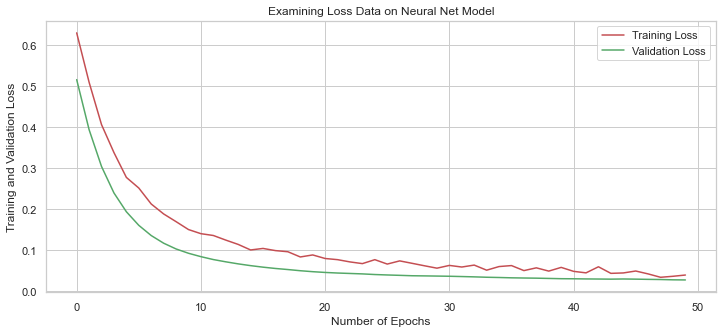

In [48]:
# create a plot to examine training and validation loss
plt.figure(figsize=(12,5))
plt.plot(loss_accuracy['loss'], 'r-', label='Training Loss')
plt.plot(loss_accuracy['val_loss'], 'g-', label='Validation Loss')
plt.ylabel('Training and Validation Loss')
plt.xlabel('Number of Epochs')
plt.title('Examining Loss Data on Neural Net Model')
plt.legend()
plt.tight_layout
plt.show()

In [49]:
print('Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Validation Recall: {:.3f}'.format(
    loss_accuracy['val_accuracy'][-1], loss_accuracy['val_loss'][-1],\
    loss_accuracy[list(loss_accuracy.keys())[-1]][-1]))

Validation Accuracy: 0.991, Validation Loss: 0.028, Validation Recall: 0.976


In [50]:
nn_model.evaluate(X_test,  y_test, verbose=1) # Examine testing accuracy and loss

4/4 [==============================] - 0s 1ms/step - loss: 0.0589 - accuracy: 0.9825 - recall: 0.9744


[0.05888367789846502, 0.9824561403508771, 0.9743589743589743]

In [51]:
nn_model.evaluate(X_train,  y_train, verbose=1) # Examine tendency to overfit

11/11 [==============================] - 0s 1ms/step - loss: 0.0337 - accuracy: 0.9912 - recall: 0.9773


[0.03374985236226639, 0.9912023460410557, 0.9772727272727273]

In [52]:
# obtain the predicted values from neural net model
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix for NN with TF and Keras:\n')
print(confusion_matrix(y_test, y_pred_nn))

Confusion Matrix for NN with TF and Keras:

[[74  1]
 [ 1 38]]


In [53]:
#create confusion matrix
conf_mat(y_test, y_pred_nn, 'Neural Nets with TF and Keras')

Performance Metrics for: Neural Nets with TF and Keras
Accuracy Score: 0.982
Receiving Operating Characteristics Score: 0.981
True Negatives: 74
False Negatives: 1
True Positives: 38
False Positives: 1
TPR: 97.436
TNR: 98.667
PPV (Precision): 97.436


In [54]:
print('Classification Report for NN with TF and Keras:\n')
print(classification_report(y_test, y_pred_nn))

Classification Report for NN with TF and Keras:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        75
           1       0.97      0.97      0.97        39

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### Neural Network Classification Code with sklearn MLP Classifier

In [55]:
from sklearn.neural_network import MLPClassifier

In [56]:
# build multilayer perceptron in scikit-learn 
nn_mlp = MLPClassifier(max_iter=1000, hidden_layer_sizes= (15,1), 
                       alpha=0.001, activation='relu', solver='adam', random_state=23)
nn_mlp.fit(X_train, y_train)
y_pred_mlp = nn_mlp.predict(X_test)

In [57]:
print(confusion_matrix(y_test, y_pred_mlp))

[[74  1]
 [ 1 38]]


In [58]:
conf_mat(y_test, y_pred_mlp, 'Neural Nets with MLP')

Performance Metrics for: Neural Nets with MLP
Accuracy Score: 0.982
Receiving Operating Characteristics Score: 0.981
True Negatives: 74
False Negatives: 1
True Positives: 38
False Positives: 1
TPR: 97.436
TNR: 98.667
PPV (Precision): 97.436


In [59]:
print('Classification Report for NN with MLP:\n')
print(classification_report(y_test, y_pred_mlp))

Classification Report for NN with MLP:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        75
           1       0.97      0.97      0.97        39

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### Decision Tree Classification Code

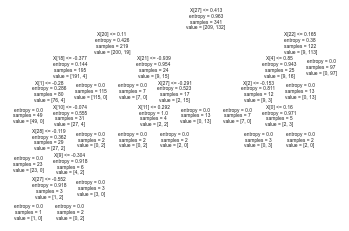

In [60]:
# build decision tree classifier in scikit-learn
dtc = DecisionTreeClassifier(criterion='entropy', random_state=23)
tree = dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)
tree_plot = sklearn.tree.plot_tree(tree)

In [61]:
# create an interpretable visual to explain the model
from sklearn.tree import export_text
r = export_text(dtc, feature_names=list(features.columns))
print(r)

|--- concave points_worst <= 0.41
|   |--- radius_worst <= 0.11
|   |   |--- symmetry_se <= -0.38
|   |   |   |--- texture_mean <= -0.28
|   |   |   |   |--- class: 0
|   |   |   |--- texture_mean >  -0.28
|   |   |   |   |--- radius_se <= -0.07
|   |   |   |   |   |--- symmetry_worst <= -0.12
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- symmetry_worst >  -0.12
|   |   |   |   |   |   |--- fractal_dimension_mean <= -0.30
|   |   |   |   |   |   |   |--- concave points_worst <= -0.55
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- concave points_worst >  -0.55
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- fractal_dimension_mean >  -0.30
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- radius_se >  -0.07
|   |   |   |   |   |--- class: 1
|   |   |--- symmetry_se >  -0.38
|   |   |   |--- class: 0
|   |--- radius_worst >  0.11
|   |   |--- texture_worst <= -0.94
|   |   |   |--- class: 0
|   |   |-

In [62]:
print('Confusion Matrix for Decision Tree Classifier:\n')
print(confusion_matrix(y_test, y_pred_dtc))

Confusion Matrix for Decision Tree Classifier:

[[73  2]
 [ 3 36]]


In [63]:
conf_mat(y_test, y_pred_dtc, 'Decision Tree Classifier')

Performance Metrics for: Decision Tree Classifier
Accuracy Score: 0.956
Receiving Operating Characteristics Score: 0.948
True Negatives: 73
False Negatives: 3
True Positives: 36
False Positives: 2
TPR: 92.308
TNR: 97.333
PPV (Precision): 94.737


In [64]:
print('Classification Report for Decision Tree Classifier:\n')
print(classification_report(y_test, y_pred_dtc))

Classification Report for Decision Tree Classifier:

              precision    recall  f1-score   support

           0       0.96      0.97      0.97        75
           1       0.95      0.92      0.94        39

    accuracy                           0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



### Random Forest Classification Code

In [65]:
# build random forest classifier in scikit-learn
rfc = RandomForestClassifier(n_estimators=128, random_state=23)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

In [66]:
print('Confusion Matrix for Random Forest Classifier:\n')
print(confusion_matrix(y_test, y_pred_rfc))

Confusion Matrix for Random Forest Classifier:

[[74  1]
 [ 3 36]]


In [67]:
conf_mat(y_test, y_pred_rfc, 'Random Forest Classifier')

Performance Metrics for: Random Forest Classifier
Accuracy Score: 0.965
Receiving Operating Characteristics Score: 0.955
True Negatives: 74
False Negatives: 3
True Positives: 36
False Positives: 1
TPR: 92.308
TNR: 98.667
PPV (Precision): 97.297


In [68]:
print('Classification Report for Random Forest Classifier:\n')
print(classification_report(y_test, y_pred_rfc))

Classification Report for Random Forest Classifier:

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        75
           1       0.97      0.92      0.95        39

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



### Recursive Feature Elimination

3 Accuracy: 0.932 and Standard Deviation: 0.032
4 Accuracy: 0.930 and Standard Deviation: 0.032
5 Accuracy: 0.930 and Standard Deviation: 0.033
6 Accuracy: 0.926 and Standard Deviation: 0.030
7 Accuracy: 0.929 and Standard Deviation: 0.034
8 Accuracy: 0.926 and Standard Deviation: 0.035
9 Accuracy: 0.922 and Standard Deviation: 0.034
10 Accuracy: 0.925 and Standard Deviation: 0.036
11 Accuracy: 0.923 and Standard Deviation: 0.033
12 Accuracy: 0.925 and Standard Deviation: 0.035
13 Accuracy: 0.924 and Standard Deviation: 0.036
14 Accuracy: 0.924 and Standard Deviation: 0.035
15 Accuracy: 0.925 and Standard Deviation: 0.034
16 Accuracy: 0.922 and Standard Deviation: 0.037
17 Accuracy: 0.921 and Standard Deviation: 0.035
18 Accuracy: 0.920 and Standard Deviation: 0.037
19 Accuracy: 0.923 and Standard Deviation: 0.035
20 Accuracy: 0.921 and Standard Deviation: 0.037
21 Accuracy: 0.919 and Standard Deviation: 0.034
22 Accuracy: 0.922 and Standard Deviation: 0.036
23 Accuracy: 0.925 and Stan

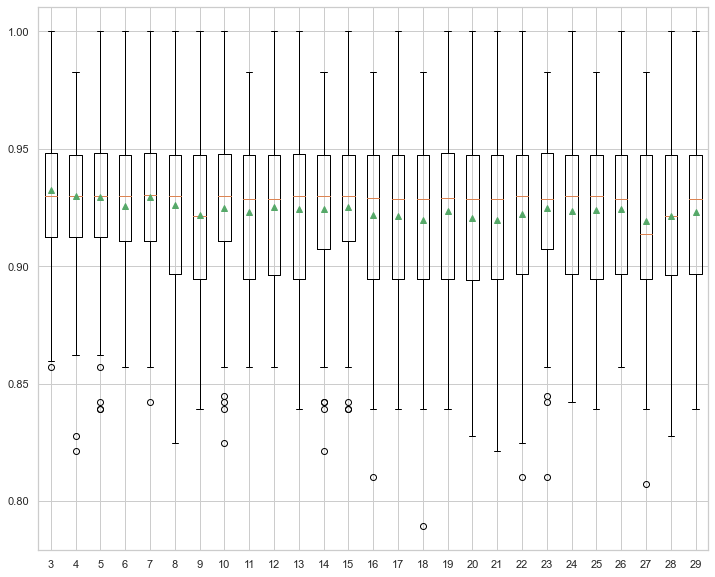

In [69]:
from sklearn.feature_selection import RFE

rfe_features = scaled_features.copy()

# Explore the right number of features to select
def get_models():
    models = dict()
    for i in range(3, 30): # using a range of features found in various WBCD research papers
        rfe = RFE(estimator = DecisionTreeClassifier(), n_features_to_select = i)
        rfe.fit(rfe_features, target)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('RFE',rfe),('DTC',model)]) # build pipeline for experimentation
    return models

def evaluate_model(model, X, y):
    # stratified 10-fold cross validation for stability verification
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, rfe_features, target)
    results.append(scores)
    names.append(name)
    print('{} Accuracy: {:.3f} and Standard Deviation: {:.3f}'.format(name, np.mean(scores), np.std(scores)))
    
# plot model performance for comparison
plt.figure(figsize=(12,10))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()



In [70]:
# test the best model by evaluating a record of data
models['3'].fit(rfe_features, target)
pipe_predict = models['3'].predict([rfe_features[0]])
if pipe_predict == [1]:
    print("Prediction is Malignant")
else:
    print("Prediction is Benign")

Prediction is Malignant


### Automatic RFE using Decision Trees (RFECV)

In [71]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=DecisionTreeClassifier())
rfecv.fit(rfe_features, target)
model = DecisionTreeClassifier()
pipeline_dtc = Pipeline(steps=[('RFECV',rfecv),('DTC',model)]) # build pipeline

# stratified 10-fold cross validation for stability verification
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
n_scores = cross_val_score(pipeline_dtc, rfe_features, target, scoring='accuracy', cv=cv,\
                           n_jobs=-1, error_score='raise')

print('Accuracy: {:.3f} and Standard Deviation: {:.3f}'.format(np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.924 and Standard Deviation: 0.037


In [72]:
# test the best model by evaluating a record of data
pipeline_dtc.fit(rfe_features, target)
pipe_predict = pipeline_dtc.predict([rfe_features[0]])
if pipe_predict == [1]:
    print("Prediction is Malignant")
else:
    print("Prediction is Benign")

Prediction is Malignant


In [73]:
# display all the features and their ranks
for k in range(len(features.columns)):
    print('{}, Chosen: {}, Rank: {}'.format(features.columns[k], rfecv.support_[k], rfecv.ranking_[k]))

radius_mean, Chosen: False, Rank: 28
texture_mean, Chosen: False, Rank: 21
perimeter_mean, Chosen: False, Rank: 22
area_mean, Chosen: False, Rank: 26
smoothness_mean, Chosen: False, Rank: 20
compactness_mean, Chosen: False, Rank: 17
concavity_mean, Chosen: False, Rank: 16
concave points_mean, Chosen: False, Rank: 3
symmetry_mean, Chosen: False, Rank: 10
fractal_dimension_mean, Chosen: False, Rank: 14
radius_se, Chosen: False, Rank: 12
texture_se, Chosen: False, Rank: 13
perimeter_se, Chosen: False, Rank: 24
area_se, Chosen: False, Rank: 6
smoothness_se, Chosen: False, Rank: 11
compactness_se, Chosen: False, Rank: 25
concavity_se, Chosen: False, Rank: 23
concave points_se, Chosen: False, Rank: 18
symmetry_se, Chosen: False, Rank: 5
fractal_dimension_se, Chosen: False, Rank: 15
radius_worst, Chosen: True, Rank: 1
texture_worst, Chosen: True, Rank: 1
perimeter_worst, Chosen: False, Rank: 8
area_worst, Chosen: False, Rank: 4
smoothness_worst, Chosen: False, Rank: 2
compactness_worst, Chose

In [74]:
# display Automatically Selected Features
num_rfe_features = len(features.columns[rfecv.support_])
features.columns[rfecv.support_]

Index(['radius_worst', 'texture_worst', 'concave points_worst'], dtype='object')

### Decision Tree Classification with RFE

In [75]:
# create the data with the 3 features chosen using RFE
X_train_df = pd.DataFrame(X_train, columns=features.columns)
X_train_rfe = np.array(X_train_df[features.columns[rfecv.support_]])
X_val_df = pd.DataFrame(X_val, columns=features.columns)
X_val_rfe = np.array(X_val_df[features.columns[rfecv.support_]])
X_test_df = pd.DataFrame(X_test, columns=features.columns)
X_test_rfe = np.array(X_test_df[features.columns[rfecv.support_]])

# train a new model using the new data
dtc_rfe = DecisionTreeClassifier(criterion='entropy', random_state=23)
tree_rfe = dtc_rfe.fit(X_train_rfe, y_train)
y_pred_dtc_rfe = dtc_rfe.predict(X_test_rfe)

In [76]:
from sklearn.tree import export_text
r = export_text(dtc_rfe, feature_names=list(features.columns[rfecv.support_]))
print(r)

|--- concave points_worst <= 0.41
|   |--- radius_worst <= 0.11
|   |   |--- texture_worst <= 0.68
|   |   |   |--- texture_worst <= -0.38
|   |   |   |   |--- class: 0
|   |   |   |--- texture_worst >  -0.38
|   |   |   |   |--- texture_worst <= -0.37
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- texture_worst >  -0.37
|   |   |   |   |   |--- class: 0
|   |   |--- texture_worst >  0.68
|   |   |   |--- concave points_worst <= -0.37
|   |   |   |   |--- class: 0
|   |   |   |--- concave points_worst >  -0.37
|   |   |   |   |--- radius_worst <= -0.40
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- radius_worst >  -0.40
|   |   |   |   |   |--- radius_worst <= -0.01
|   |   |   |   |   |   |--- texture_worst <= 1.10
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- texture_worst >  1.10
|   |   |   |   |   |   |   |--- radius_worst <= -0.28
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- radius_worst >  -0.28
|   |   |

In [77]:
print('Confusion Matrix for Decision Tree Classifier with RFE:\n')
print(confusion_matrix(y_test, y_pred_dtc_rfe))

Confusion Matrix for Decision Tree Classifier with RFE:

[[74  1]
 [ 5 34]]


In [78]:
conf_mat(y_test, y_pred_dtc_rfe, 'Decision Tree Classifier with RFE')

Performance Metrics for: Decision Tree Classifier with RFE
Accuracy Score: 0.947
Receiving Operating Characteristics Score: 0.929
True Negatives: 74
False Negatives: 5
True Positives: 34
False Positives: 1
TPR: 87.179
TNR: 98.667
PPV (Precision): 97.143


In [79]:
print('Classification Report for Decision Tree Classifier with RFE:\n')
print(classification_report(y_test, y_pred_dtc_rfe))

Classification Report for Decision Tree Classifier with RFE:

              precision    recall  f1-score   support

           0       0.94      0.99      0.96        75
           1       0.97      0.87      0.92        39

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



### Random Forest Classification with RFE

In [80]:
rfc_rfe = RandomForestClassifier(n_estimators=32, random_state=23)
rfc_rfe.fit(X_train_rfe, y_train)
y_pred_rfc_rfe = rfc_rfe.predict(X_test_rfe)

In [81]:
print('Confusion Matrix for Random Forest Classifier:\n')
print(confusion_matrix(y_test, y_pred_rfc_rfe))

Confusion Matrix for Random Forest Classifier:

[[75  0]
 [ 6 33]]


In [82]:
conf_mat(y_test, y_pred_rfc_rfe, 'Random Forest Classifier with RFE')

Performance Metrics for: Random Forest Classifier with RFE
Accuracy Score: 0.947
Receiving Operating Characteristics Score: 0.923
True Negatives: 75
False Negatives: 6
True Positives: 33
False Positives: 0
TPR: 84.615
TNR: 100.000
PPV (Precision): 100.000


In [83]:
print('Classification Report for Random Forest Classifier:\n')
print(classification_report(y_test, y_pred_rfc_rfe))

Classification Report for Random Forest Classifier:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        75
           1       1.00      0.85      0.92        39

    accuracy                           0.95       114
   macro avg       0.96      0.92      0.94       114
weighted avg       0.95      0.95      0.95       114



### Neural Networks Classification with RFE

In [84]:
tf.keras.backend.set_floatx('float64')
nn_model_rfe = Sequential()

nn_model_rfe.add(Dense(num_rfe_features, activation='relu'))
nn_model_rfe.add(Dropout(0.1))

nn_model_rfe.add(Dense(2, activation='relu'))
nn_model_rfe.add(Dropout(0.1))

nn_model_rfe.add(Dense(units=1, activation='sigmoid'))

In [85]:
nn_model_rfe.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

In [86]:
history_rfe = nn_model_rfe.fit(X_train_rfe, y_train, epochs=50, verbose=1, validation_data=(X_val_rfe, y_val))

Epoch 1/50
11/11 [==============================] - 0s 20ms/step - loss: 0.7538 - accuracy: 0.2933 - recall_1: 0.5000 - val_loss: 0.7415 - val_accuracy: 0.2368 - val_recall_1: 0.6585
Epoch 2/50
11/11 [==============================] - 0s 4ms/step - loss: 0.7365 - accuracy: 0.3196 - recall_1: 0.5303 - val_loss: 0.7277 - val_accuracy: 0.2719 - val_recall_1: 0.5854
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 0.7278 - accuracy: 0.3255 - recall_1: 0.4697 - val_loss: 0.7161 - val_accuracy: 0.3684 - val_recall_1: 0.5122
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.4311 - recall_1: 0.4848 - val_loss: 0.7064 - val_accuracy: 0.4211 - val_recall_1: 0.5122
Epoch 5/50
11/11 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.4340 - recall_1: 0.4621 - val_loss: 0.6991 - val_accuracy: 0.5088 - val_recall_1: 0.5122
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy

Epoch 46/50
11/11 [==============================] - 0s 3ms/step - loss: 0.5654 - accuracy: 0.8094 - recall_1: 0.7197 - val_loss: 0.5549 - val_accuracy: 0.8070 - val_recall_1: 0.7073
Epoch 47/50
11/11 [==============================] - 0s 3ms/step - loss: 0.5548 - accuracy: 0.8123 - recall_1: 0.7424 - val_loss: 0.5488 - val_accuracy: 0.8070 - val_recall_1: 0.7073
Epoch 48/50
11/11 [==============================] - 0s 3ms/step - loss: 0.5507 - accuracy: 0.8240 - recall_1: 0.7424 - val_loss: 0.5426 - val_accuracy: 0.8158 - val_recall_1: 0.7317
Epoch 49/50
11/11 [==============================] - 0s 4ms/step - loss: 0.5466 - accuracy: 0.8182 - recall_1: 0.7500 - val_loss: 0.5361 - val_accuracy: 0.8158 - val_recall_1: 0.7317
Epoch 50/50
11/11 [==============================] - 0s 3ms/step - loss: 0.5409 - accuracy: 0.8182 - recall_1: 0.7273 - val_loss: 0.5297 - val_accuracy: 0.8246 - val_recall_1: 0.7317


In [87]:
nn_model_rfe.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3)                 12        
_________________________________________________________________
dropout_2 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 8         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


In [88]:
loss_accuracy_rfe = history_rfe.history

In [89]:
loss_accuracy_rfe.keys()

dict_keys(['loss', 'accuracy', 'recall_1', 'val_loss', 'val_accuracy', 'val_recall_1'])

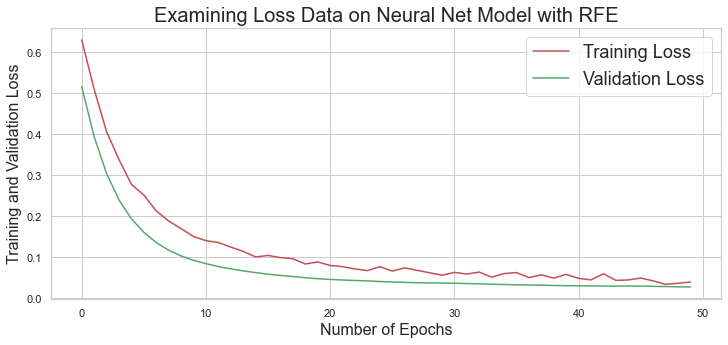

In [90]:
plt.figure(figsize=(12,5))
plt.plot(loss_accuracy['loss'], 'r-', label='Training Loss')
plt.plot(loss_accuracy['val_loss'], 'g-', label='Validation Loss')
plt.ylabel('Training and Validation Loss', fontsize=16)
plt.xlabel('Number of Epochs', fontsize=16)
plt.title('Examining Loss Data on Neural Net Model with RFE', fontsize=20)
plt.legend(fontsize=18)
plt.show()

In [91]:
print('Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Validation Recall: {:.3f}'.format(
    loss_accuracy_rfe['val_accuracy'][-1], loss_accuracy_rfe['val_loss'][-1], \
    loss_accuracy_rfe[list(loss_accuracy_rfe.keys())[-1]][-1]))

Validation Accuracy: 0.825, Validation Loss: 0.530, Validation Recall: 0.732


In [92]:
nn_model_rfe.evaluate(X_test_rfe,  y_test, verbose=1) # Examine testing accuracy and loss

4/4 [==============================] - 0s 1ms/step - loss: 0.5206 - accuracy: 0.9035 - recall_1: 0.7436


[0.5206294802197239, 0.9035087719298246, 0.7435897435897436]

In [93]:
nn_model_rfe.evaluate(X_train_rfe,  y_train, verbose=1)

11/11 [==============================] - 0s 1ms/step - loss: 0.5172 - accuracy: 0.8592 - recall_1: 0.8409


[0.5171509519700082, 0.8592375366568915, 0.8409090909090909]

In [94]:
y_pred_nn_rfe = (nn_model_rfe.predict(X_test_rfe) > 0.5).astype("int32")
print('Confusion Matrix for NN with TF and RFE:\n')
print(confusion_matrix(y_test, y_pred_nn_rfe))

Confusion Matrix for NN with TF and RFE:

[[74  1]
 [10 29]]


In [95]:
conf_mat(y_test, y_pred_nn_rfe, 'Neural Nets with TF and RFE')

Performance Metrics for: Neural Nets with TF and RFE
Accuracy Score: 0.904
Receiving Operating Characteristics Score: 0.865
True Negatives: 74
False Negatives: 10
True Positives: 29
False Positives: 1
TPR: 74.359
TNR: 98.667
PPV (Precision): 96.667


In [96]:
print('Classification Report for NN with TF and RFE:\n')
print(classification_report(y_test, y_pred_nn_rfe))

Classification Report for NN with TF and RFE:

              precision    recall  f1-score   support

           0       0.88      0.99      0.93        75
           1       0.97      0.74      0.84        39

    accuracy                           0.90       114
   macro avg       0.92      0.87      0.89       114
weighted avg       0.91      0.90      0.90       114



In [97]:
# obtain all the performance metrics for all the models
(nn_tf_acc, nn_tf_roc, nn_tf_tpr, nn_tf_tnr, nn_tf_ppv) = perf_scores(y_test, y_pred_nn)
(dtc_acc, dtc_roc, dtc_tpr, dtc_tnr, dtc_ppv) = perf_scores(y_test, y_pred_dtc)
(rfc_acc, rfc_roc, rfc_tpr, rfc_tnr, rfc_ppv) = perf_scores(y_test, y_pred_rfc)
(nn_tf_rfe_acc, nn_tf_rfe_roc, nn_tf_rfe_tpr, nn_tf_rfe_tnr, nn_tf_rfe_ppv) = perf_scores(y_test, y_pred_nn_rfe)
(dtc_rfe_acc, dtc_rfe_roc, dtc_rfe_tpr, dtc_rfe_tnr, dtc_rfe_ppv) = perf_scores(y_test, y_pred_dtc_rfe)
(rfc_rfe_acc, rfc_rfe_roc, rfc_rfe_tpr, rfc_rfe_tnr, rfc_rfe_ppv) = perf_scores(y_test, y_pred_rfc_rfe)

<Figure size 720x288 with 0 Axes>

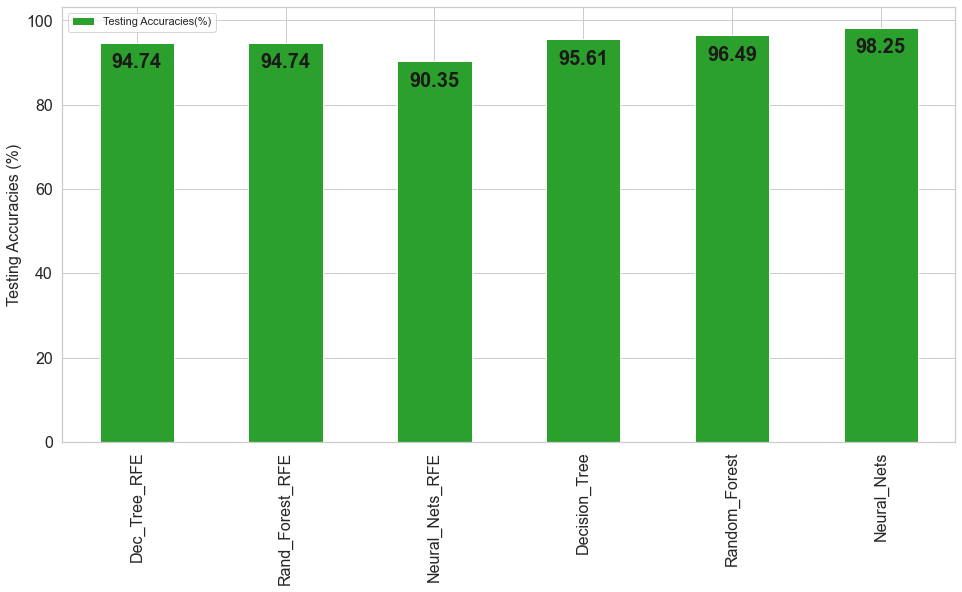

In [98]:
model_names = ['Dec_Tree_RFE', 'Rand_Forest_RFE', 'Neural_Nets_RFE', 'Decision_Tree', 'Random_Forest', 'Neural_Nets']
test_acc = np.array([dtc_rfe_acc, rfc_rfe_acc, nn_tf_rfe_acc, dtc_acc, rfc_acc,\
            nn_tf_acc]).reshape(6,1)* 100 # compile all the values and transpose the list

model_acc = pd.DataFrame(data=test_acc, index=model_names, 
                    columns=['Testing Accuracies(%)'])

fig = plt.figure(figsize=(10,4))
ax = model_acc.plot(kind='bar', figsize=(16,8), fontsize=16, color='tab:green')
for p in ax.patches:
    # create and annotate bars that represent the performance metric
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 
    p.get_height()),ha='center', va='center', rotation=0, xytext=(0, -20), 
    textcoords='offset points', fontsize=20, fontweight='bold', color='k')
#ax.legend(bbox_to_anchor=(1, 1), ncol=1, fontsize=16)
plt.ylabel('Testing Accuracies (%)', fontsize=16)
plt.show()

<Figure size 720x288 with 0 Axes>

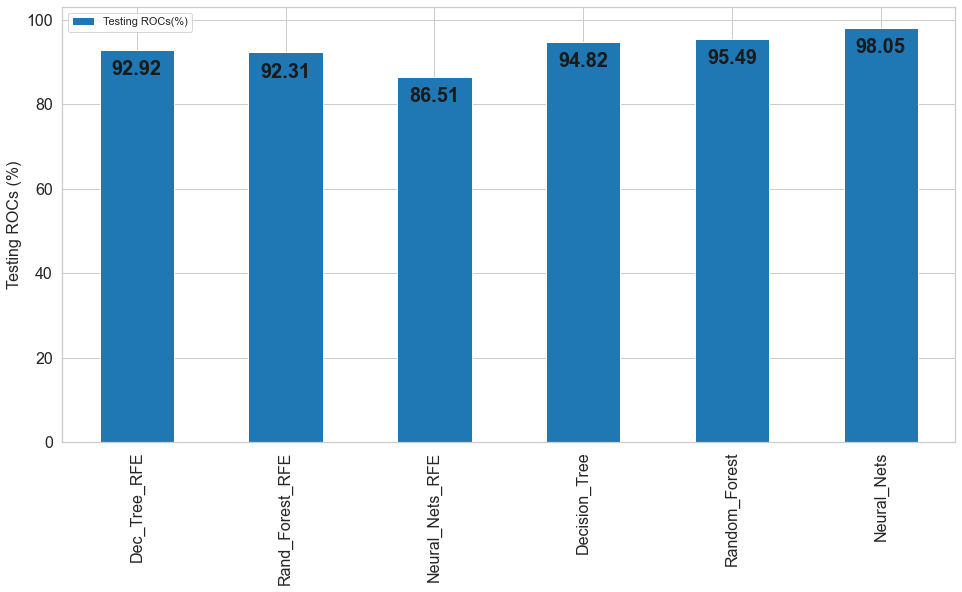

In [99]:
test_roc = np.array([dtc_rfe_roc, rfc_rfe_roc, nn_tf_rfe_roc, dtc_roc, rfc_roc,\
            nn_tf_roc]).reshape(6,1) * 100

model_roc = pd.DataFrame(data=test_roc, index=model_names, 
                    columns=['Testing ROCs(%)'])

fig = plt.figure(figsize=(10,4))
ax = model_roc.plot(kind='bar', figsize=(16,8), fontsize=16, color='tab:blue')
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 
    p.get_height()),ha='center', va='center', rotation=0, xytext=(0, -20), 
    textcoords='offset points', fontsize=20, fontweight='bold', color='k')
#ax.legend(bbox_to_anchor=(1, 1), ncol=1, fontsize=16)
plt.ylabel('Testing ROCs (%)', fontsize=16)
plt.show()

<Figure size 720x288 with 0 Axes>

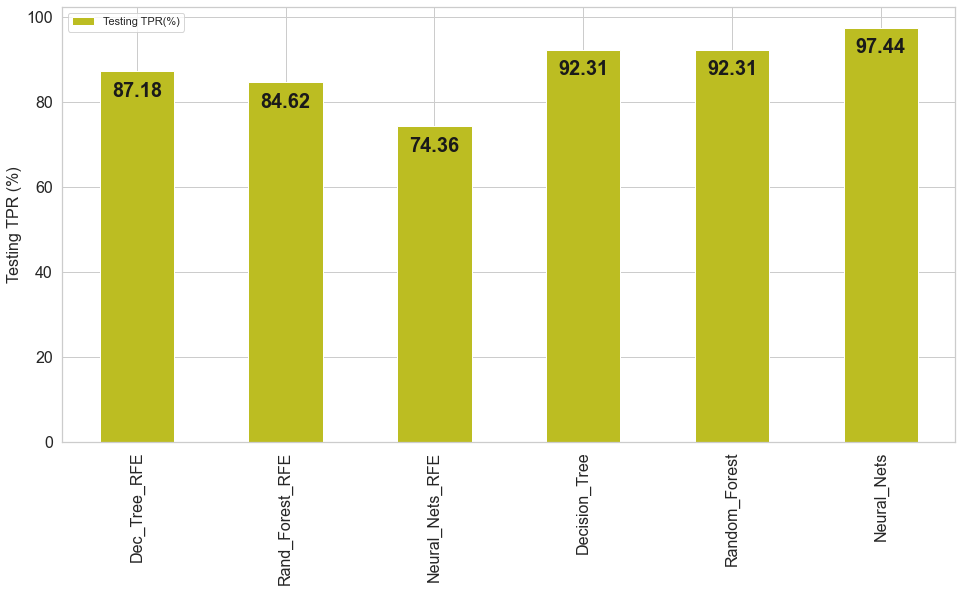

In [100]:
model_names = ['Dec_Tree_RFE', 'Rand_Forest_RFE', 'Neural_Nets_RFE', 'Decision_Tree', 'Random_Forest', 'Neural_Nets']
test_tpr = np.array([dtc_rfe_tpr, rfc_rfe_tpr, nn_tf_rfe_tpr, dtc_tpr, rfc_tpr,\
            nn_tf_tpr]).reshape(6,1)

model_tpr = pd.DataFrame(data=test_tpr, index=model_names, 
                    columns=['Testing TPR(%)'])

fig = plt.figure(figsize=(10,4))
ax = model_tpr.plot(kind='bar', figsize=(16,8), fontsize=16, color='tab:olive')
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 
    p.get_height()),ha='center', va='center', rotation=0, xytext=(0, -20), 
    textcoords='offset points', fontsize=20, fontweight='bold', color='k')
#ax.legend(bbox_to_anchor=(1, 1), ncol=1, fontsize=16)
plt.ylabel('Testing TPR (%)', fontsize=16)
plt.show()

<Figure size 720x288 with 0 Axes>

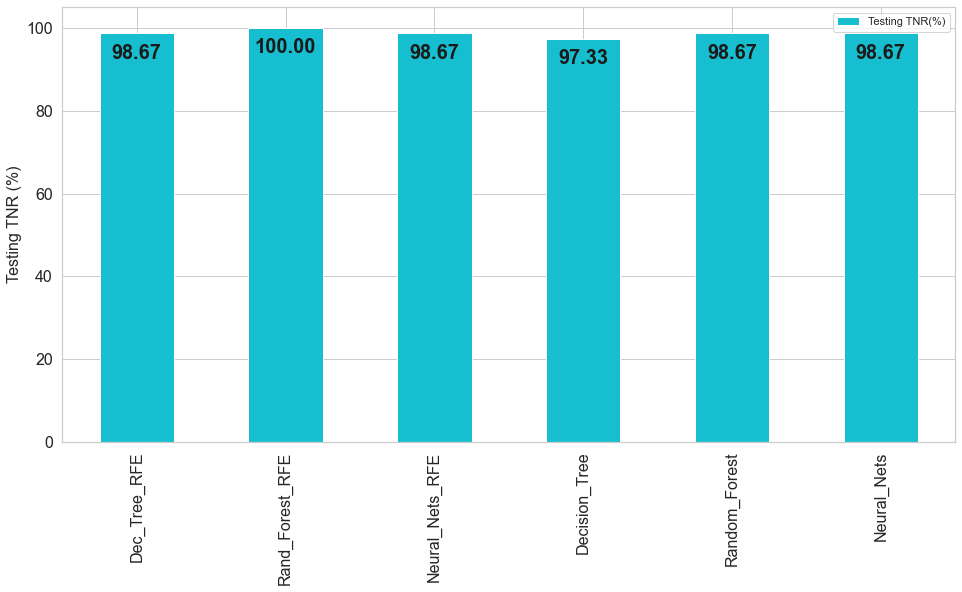

In [101]:
test_tnr = np.array([dtc_rfe_tnr, rfc_rfe_tnr, nn_tf_rfe_tnr, dtc_tnr, rfc_tnr,\
            nn_tf_tnr]).reshape(6,1)

model_tnr = pd.DataFrame(data=test_tnr, index=model_names, 
                    columns=['Testing TNR(%)'])

fig = plt.figure(figsize=(10,4))
ax = model_tnr.plot(kind='bar', figsize=(16,8), fontsize=16, color='tab:cyan')
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 
    p.get_height()),ha='center', va='center', rotation=0, xytext=(0, -20), 
    textcoords='offset points', fontsize=20, fontweight='bold', color='k')
#ax.legend(bbox_to_anchor=(1, 1), ncol=1, fontsize=16)
plt.ylabel('Testing TNR (%)', fontsize=16)
plt.show()

<Figure size 720x288 with 0 Axes>

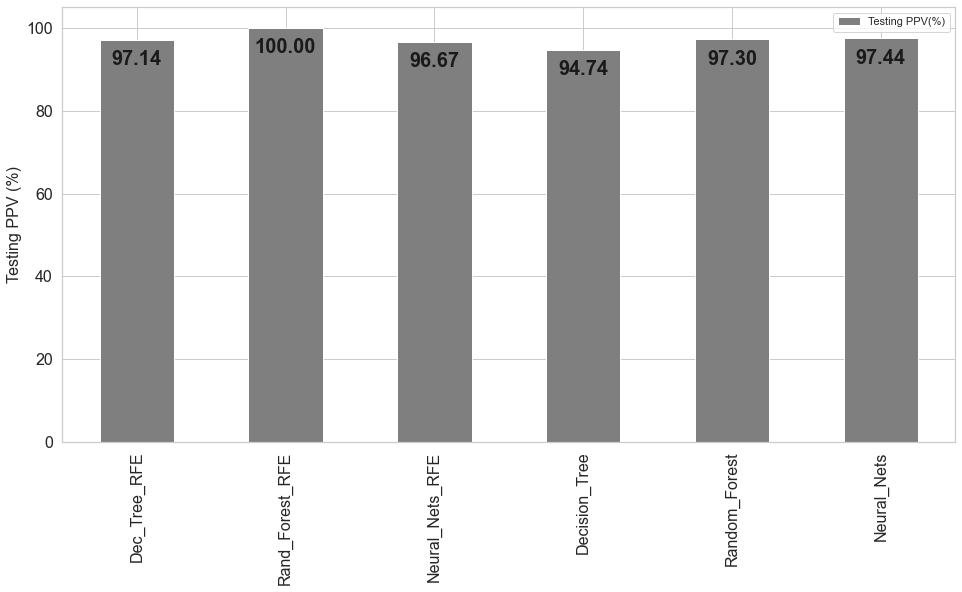

In [102]:
test_ppv = np.array([dtc_rfe_ppv, rfc_rfe_ppv, nn_tf_rfe_ppv, dtc_ppv, rfc_ppv,\
            nn_tf_ppv]).reshape(6,1)

model_ppv = pd.DataFrame(data=test_ppv, index=model_names, 
                    columns=['Testing PPV(%)'])

fig = plt.figure(figsize=(10,4))
ax = model_ppv.plot(kind='bar', figsize=(16,8), fontsize=16, color='tab:gray')
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 
    p.get_height()),ha='center', va='center', rotation=0, xytext=(0, -20), 
    textcoords='offset points', fontsize=20, fontweight='bold', color='k')
#ax.legend(bbox_to_anchor=(1, 1), ncol=1, fontsize=16)
plt.ylabel('Testing PPV (%)', fontsize=16)
plt.show()

In [103]:
print('--- {:.3f} seconds ---'.format(time.time() - start_time))

--- 153.526 seconds ---
